In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import glob
import matplotlib.pyplot as plt
from time import strftime

In [2]:
def get_bkg_features(sets_of_npzs, weights, n_target_events=10000):
    """
    Gets a combined, weighted combination of events
    """
    weights /= np.sum(weights) # normalize
    print(f'weights: {weights}')
    n_events_per_set = (weights * n_target_events).astype(np.int32)

    print(f'n_events per set: {n_events_per_set}')
    X_combined = []
    for n_events, npzs in zip(n_events_per_set, sets_of_npzs):
        print(f'n_events: {n_events}')
        n_events_todo = n_events
        for npz in npzs:
            X = np.load(npz)['X'][:,:10]
            n_events_this_npz = X.shape[0]
            if n_events_this_npz > n_events_todo:
                X = X[:n_events_todo]
                
            X_combined.append(X)
            n_events_todo -= X.shape[0]
            if n_events_todo == 0: break
        else:
            print(f'Warning: reached end of set of files with n_events_todo={n_events_todo}')
    X_final = np.vstack(X_combined)
    
    assert len(X_final.shape) == 2
    assert X_final.shape[1] == 10
    return X_final

In [3]:
#labels = ['QCD_Pt_300to470', 'QCD_Pt_470to600', 'QCD_Pt_600to800', 'QCD_Pt_800to1000', 'QCD_Pt_1000to1400', 'SingleLeptFromTbar_TuneCP5', 'SingleLeptFromT_TuneCP5','TTJets_TuneCP5_13TeV', 'HT-600to800', 'HT-800to1200', 'HT-1200to2500', 'HT-2500toInf'] #ttjets bins are taken from AN2019-061 v15
#crosssections = [6826.0, 552.6, 156.6, 26.32, 7.50, 831.76*0.219, 831.76*0.219, 831.76, 1.808, 0.7490, 0.1315, 0.001420] #values of cross sections taken from https://github.com/tklijnsma/svj-bdt/blob/main/crosssections.py

#labels = ['SingleLeptFromTbar_TuneCP5', 'SingleLeptFromT_TuneCP5','TTJets_TuneCP5_13TeV', 'HT-600to800', 'HT-800to1200','HT-1200to2500', 'HT-2500toInf']
#crosssections = [831.76*0.219, 831.76*0.219, 831.76, 1.808, 0.7490, 0.1315, 0.001420] #values of cross sections taken from https://github.com/tklijnsma/svj-bdt/blob/main/crosssections.py

labels = ['QCD_Pt_1000to1400']
crosssections = [7.50*0.0438]

#labels = ['QCD_Pt_300to470', 'QCD_Pt_470to600', 'QCD_Pt_600to800', 'QCD_Pt_800to1000', 'QCD_Pt_1000to1400']
#crosssections = [6826.0, 552.6, 156.6, 26.32, 7.50]
sets_of_npzs = [ glob.iglob(f'/home/snabili/data/bdt/svj-bdt/data/bkg_all/*{l}*/*.npz') for l in labels ]
#print(f'crosssections: ', crosssections)
#print(f'sets of npzs: ', sets_of_npzs)
X_bkg = get_bkg_features(sets_of_npzs, crosssections)
X_bkg
#print(f'length of X_bkg',len(X_bkg))
y_bkg = np.zeros(X_bkg.shape[0])

weights: [1.]
n_events per set: [10000]
n_events: 10000


In [6]:
def get_sig_features(sets_of_npzs, weights, n_target_events=7000):
    """
    Gets a combined, weighted combination of events
    """
    weights /= np.sum(weights) # normalize
    print(f'weights: {weights}')
    n_events_per_set = (weights * n_target_events).astype(np.int32)

    print(f'n_events per set: {n_events_per_set}')

    X_combined = []
    for n_events, npzs in zip(n_events_per_set, sets_of_npzs):
        print(f'n_events: {n_events}')
        n_events_todo = n_events
        for npz in npzs:
            #print(f'npz files: {npz}')
            X = np.load(npz)['X'][:,:10]
            #X = np.load(npz)
            n_events_this_npz = X.shape[0]
            if n_events_this_npz > n_events_todo:
                X = X[:n_events_todo]
            X_combined.append(X)
            n_events_todo -= X.shape[0]
            if n_events_todo == 0: break
        else:
            print(f'Warning: reached end of set of files with n_events_todo={n_events_todo}')

    X_final = np.vstack(X_combined)
    assert len(X_final.shape) == 2
    assert X_final.shape[1] == 10
    return X_final

In [7]:
labels_sig = ['mz250', 'mz300', 'mz350', 'mz400', 'mz450']
sig_xsec = [1,1,1,1]
#labels_sig = ['mz300', 'mz350', 'mz400', 'mz450']
#labels_sig = ['mz400']
#sig_xsec = [1]
sig_npzfiles = [ glob.iglob(f'/data/users/snabili/bdt/svj-bdt/data/signal/*{l}*/*.npz') for l in labels_sig ]
X_signal = get_sig_features(sig_npzfiles, sig_xsec)
y_signal = np.ones(X_signal.shape[0])

weights: [0.25 0.25 0.25 0.25]
n_events per set: [1750 1750 1750 1750]
n_events: 1750
n_events: 1750
n_events: 1750
n_events: 1750


In [73]:
X = np.vstack((X_signal, X_bkg))
y = np.concatenate((y_signal, y_bkg)).astype(np.int8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
y_train = y_train.astype(np.int8)
y_test = y_test.astype(np.int8)

In [74]:
y_train

array([0, 0, 0, ..., 0, 1, 0], dtype=int8)

In [75]:
model = xgb.XGBClassifier(
    eta=.03, scale_pos_weight=y.shape[0]/np.sum(y),
    #max_depth=3,
    #n_estimators=850,
    max_depth=4,
    n_estimators=1000,

    )
model.fit(X_train, y_train)

# NTrees=850
# MinNodeSize=2.5%
# MaxDepth=3
# BoostType=AdaBoost
# AdaBoostBeta=0.5
# UseBaggedBoost
# BaggedSampleFraction=0.5
# SeparationType=GiniIndex
# nCuts=20


/home/snabili/miniconda3/envs/svj-bdt/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.03, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0299999993, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=7.63129973474801,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [76]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
confusion_matrix(y_test, y_pred)

array([[1894,  105],
       [  36,  267]])

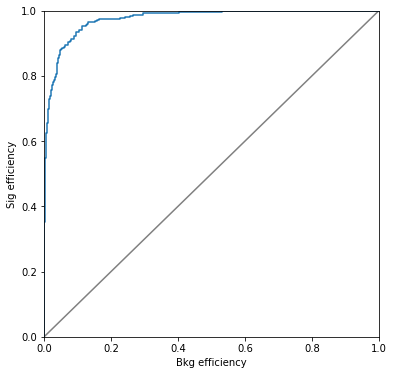

In [77]:
eff_bkg, eff_sig, cuts = roc_curve(y_test, y_prob)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.plot([0,1], [0,1], c='gray')
ax.plot(eff_bkg, eff_sig)
ax.set_ylim(0., 1.)
ax.set_xlim(0., 1.)
ax.set_xlabel('Bkg efficiency')
ax.set_ylabel('Sig efficiency')
fig.savefig('bdt_roccurve.pdf')

In [78]:
i_wp = np.argmax(eff_bkg >= .05)
print(f'eff_sig: {eff_sig[i_wp]:.3f}, bkg_eff: {eff_bkg[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')

i_wp = np.argmax(eff_bkg >= .31)
print(f'eff_sig: {eff_sig[i_wp]:.3f}, bkg_eff: {eff_bkg[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')

eff_sig: 0.878, bkg_eff: 0.052, cut: 0.505
eff_sig: 0.993, bkg_eff: 0.403, cut: 0.009


In [79]:
model.save_model(strftime('svjbdt_%b%d.json'))

In [80]:
auc(eff_bkg, eff_sig)

0.9752169814280078

In [81]:
y_prob_sig = y_prob[y_test == 1]
y_prob_bkg = y_prob[y_test == 0]

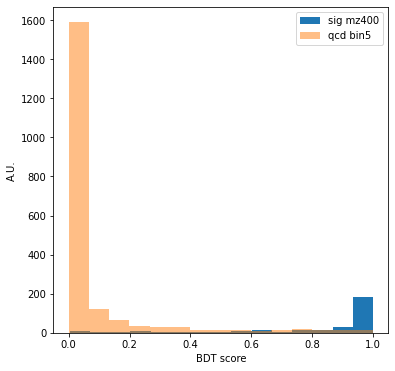

In [87]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

ax.hist(y_prob_sig, label='sig mz400', density=False, bins=15)
ax.hist(y_prob_bkg, label='qcd bin5', alpha=.5, density=False, bins=15)
ax.legend()
ax.set_ylabel('A.U.')
ax.set_xlabel('BDT score')
fig.savefig('bdtscores_allsig.png')
fig.savefig('bdtscores_allsig.pdf')

In [33]:
corrmat = np.corrcoef(X)
corrmat = np.corrcoef(X.T)

In [34]:
corrmat.shape

(10, 10)

/tmp/ipykernel_878650/3557691023.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels, rotation=90)
/tmp/ipykernel_878650/3557691023.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)


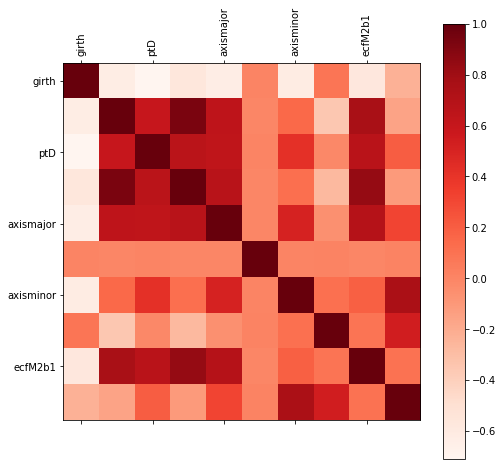

In [35]:
labels = ['girth', 'ptD', 'axismajor', 'axisminor', 'ecfM2b1', 'ecfD2b1', 'ecfC2b1', 'ecfN2b2', 'metdphi']
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
mshow = ax.matshow(corrmat, cmap=plt.cm.Reds)
ax.set_xticklabels(['']+labels, rotation=90)
ax.set_yticklabels(['']+labels)
fig.savefig('correlationmatrix.pdf')

cbar = fig.colorbar(mshow)
cbar
y_prob_sig.dtype = [('y_prob_sig', 'float32')]
y_prob_bkg.dtype = [('y_prob_bkg', 'float32')]

In [ ]:
import numpy as np
#data = np.load("../data/signal.npz")
#data.files
data = np.load("../data/signal.npz")['X'][:,:1]
data
#print(f'data first item is: {data.items()}')
#data[0]
#print('*'*50)
#data[1]
#all = [('data', 'float32')]
#y_prob_bkg.dtype = [('y_prob_bkg', 'float32')]
#array2root(all, "test.root", "tree1")

In [ ]:
plt.cm.Reds

## Check model IO

In [29]:
model2 = xgb.XGBClassifier()
model2.load_model('svjbdt_Nov11.json')

In [47]:
bdt = model2.predict_proba(X_test)

(array([[427., 626., 684., 546., 435., 420., 414., 482., 513., 933.],
        [933., 513., 482., 414., 420., 435., 546., 684., 626., 427.]]),
 array([1.2790228e-04, 1.0010232e-01, 2.0007674e-01, 3.0005115e-01,
        4.0002558e-01, 5.0000000e-01, 5.9997439e-01, 6.9994885e-01,
        7.9992324e-01, 8.9989769e-01, 9.9987209e-01], dtype=float32),
 <a list of 2 BarContainer objects>)

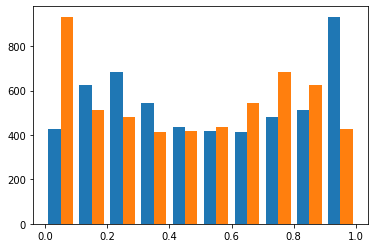

In [49]:
plt.hist(bdt)

In [39]:
model2.predict_proba(X_train[:2])

array([[0.25703293, 0.74296707],
       [0.15279174, 0.84720826]], dtype=float32)